In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision import datasets
import torch._dynamo
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split




torch._dynamo.config.suppress_errors = True


# Check for CUDA and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the directory of my dataset
data_dir = "./DATA_LABELS"  # Modify with your correct path

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHS = 3
N_CLASSES = 3


# Define transformations
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),  # resize the images
    transforms.ToTensor(),# converting to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #normalization
])


#read image files directly and infer the label based on the filepath
class ProteinsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = datasets.ImageFolder(data_dir, transform=transform)
       
    
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def classes(self):
        return self.data.classes
    
dataset=ProteinsDataset(data_dir, transform)

# Extract labels for stratified splitting
labels = np.array([dataset[i][1] for i in range(len(dataset))])  #(image, label) tuple

# Reserve 10% of the data as the test set
train_val_indices, test_indices, _, _ = train_test_split(
    np.arange(len(labels)),
    labels,
    test_size=0.1,
    stratify=labels,
    random_state=42
)

# Create 2 datasets
train_val_dataset = Subset(dataset, train_val_indices)
test_dataset = Subset(dataset, test_indices)


batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_N = len(test_loader.dataset)


#creating the CNN model
class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3  # convolution filter size 
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)
flattened_img_size = 128 * 8 * 8 # 128 is the final output and the 8*8 is reduced from 128×128 due to pooling and strides

# Input 3 x 128 x 128
model = nn.Sequential(
    MyConvBlock(IMG_CHS, 16, 0), # First convolution 25 x 14 x 14
    MyConvBlock(16, 32, 0.1), # Second convolution 50 x 7 x 7
    MyConvBlock(32, 64, 0.1),  # Third convolution  64 x 3 x 3
    MyConvBlock(64, 128, 0.1),  # Forth convolution  128 x 8 x 8
    
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.2),
    nn.LeakyReLU(),
    nn.Linear(512, N_CLASSES)
)
model = torch.compile(model.to(device))
model





def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

#augmentation
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),#20% chance to flip images horizontally
    transforms.RandomVerticalFlip(p=0.2),  # 20% chance to vertically flip the image

])

# the training function

train_losses, train_accuracies = [], [] #creating two variables to store the accuracy and loss over the epoches 
#defining a training fuction
def train(train_loader,train_N):
    loss = 0
    accuracy = 0

    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(augment(images))
        optimizer.zero_grad()
        batch_loss = loss_function(output, labels)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, labels, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    train_loss = loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)

#validation function

valid_losses,valid_accuracies = [],[]#creating two variables to store the accuracy and loss over the epoches
#definding a validation function
def validate(valid_loader,valid_N):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)

            loss += loss_function(output, labels).item()
            accuracy += get_batch_accuracy(output, labels, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    valid_loss = loss / len(valid_loader)
    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

#training loop


# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, valid_loss):
        if self.best_loss is None:
            self.best_loss = valid_loss
        elif valid_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = valid_loss
            self.counter = 0

k_folds = 5 #number of folds
# Define StratifiedKFold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
# Extract labels for stratified splitting
labelskf = np.array([sample[1] for sample in train_val_dataset])
# StratifiedKFold splits
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labelskf)), labelskf)):
    print(f"Fold {fold + 1}/{k_folds}")
    #data subsets
    train_subset = Subset(train_val_dataset, train_idx)
    valid_subset = Subset(train_val_dataset, val_idx)
    #dataloaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)
 # Get the number of batches
    train_N = len(train_loader)
    valid_N = len(valid_loader)
# Initialize  optimizer and loss function
    loss_function = nn.CrossEntropyLoss()
    # Define the optimizer with L2 weight decay
    optimizer = Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)

    # Early stopping
    early_stopping = EarlyStopping(patience=10, verbose=True)
 # Training epochs
    epochs = 20
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        train(train_loader, train_N)
        validate(valid_loader, valid_N)

        # Early stopping
        early_stopping(valid_losses[-1])
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    print(f"Fold {fold + 1} finished.")

cuda
Fold 1/5

Epoch 1/20


c:\Users\Dana\Desktop\project\.venv\lib\site-packages\torch\_inductor\compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W1222 04:45:48.821957 13684 Lib\site-packages\torch\_dynamo\convert_frame.py:1125] WON'T CONVERT inner c:\Users\Dana\Desktop\project\.venv\lib\site-packages\torch\_dynamo\external_utils.py line 38 
W1222 04:45:48.821957 13684 Lib\site-packages\torch\_dynamo\convert_frame.py:1125] due to: 
W1222 04:45:48.821957 13684 Lib\site-packages\torch\_dynamo\convert_frame.py:1125] Traceback (most recent call last):
W1222 04:45:48.821957 13684 Lib\site-packages\torch\_dynamo\convert_frame.py:1125]   File "c:\Users\Dana\Desktop\project\.venv\lib\site-packages\torch\_dynamo\output_graph.py", line 1446, in _call_user_compiler
W1222 04:45:48.821957 13684 Lib\site-packages\torch\_dynamo\convert_frame.py:1125]     c

Train - Loss: 32.3158 Accuracy: 33.8182
Valid - Loss: 8.5315 Accuracy: 34.7778

Epoch 2/20
Train - Loss: 27.5766 Accuracy: 41.7273
Valid - Loss: 7.2620 Accuracy: 40.7778

Epoch 3/20
Train - Loss: 24.2931 Accuracy: 44.5758
Valid - Loss: 6.5349 Accuracy: 42.4444

Epoch 4/20
Train - Loss: 22.2365 Accuracy: 46.6364
Valid - Loss: 6.0948 Accuracy: 44.2222

Epoch 5/20
Train - Loss: 21.0665 Accuracy: 46.5455
Valid - Loss: 5.7747 Accuracy: 44.3333

Epoch 6/20
Train - Loss: 19.4745 Accuracy: 48.2121
Valid - Loss: 5.6939 Accuracy: 44.2222

Epoch 7/20
Train - Loss: 19.0378 Accuracy: 49.5455
Valid - Loss: 5.4070 Accuracy: 44.7778

Epoch 8/20
Train - Loss: 18.0866 Accuracy: 50.0303
Valid - Loss: 5.3245 Accuracy: 44.1111

Epoch 9/20
Train - Loss: 17.7868 Accuracy: 50.1818
Valid - Loss: 5.2445 Accuracy: 44.7778

Epoch 10/20
Train - Loss: 17.2653 Accuracy: 50.0909
Valid - Loss: 5.2378 Accuracy: 44.8889

Epoch 11/20
Train - Loss: 16.8753 Accuracy: 50.6970
Valid - Loss: 5.2001 Accuracy: 45.3333

Epoch 12

Visualize Losses

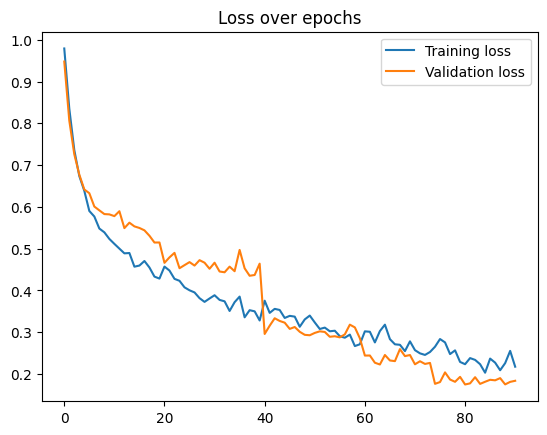

In [2]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

Visualize Losses

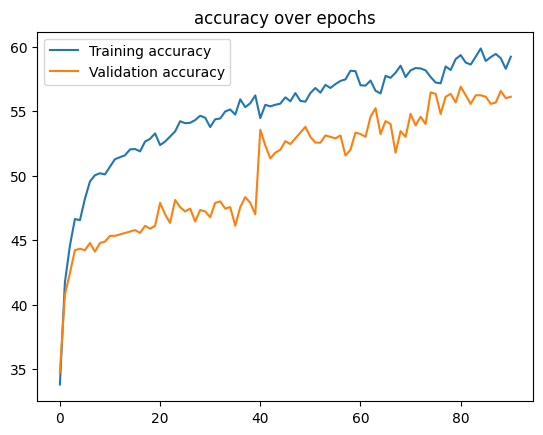

In [3]:
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Validation accuracy')
plt.legend()
plt.title("accuracy over epochs")
plt.show()

evaluation function 

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       100
           1       0.94      0.70      0.80        92
           2       0.88      0.82      0.85       100

    accuracy                           0.82       292
   macro avg       0.84      0.82      0.82       292
weighted avg       0.84      0.82      0.82       292

Confusion Matrix:
[[93  1  6]
 [23 64  5]
 [15  3 82]]
accuracy score: 0.8184931506849316
area under the curve: 0.9605004528985508


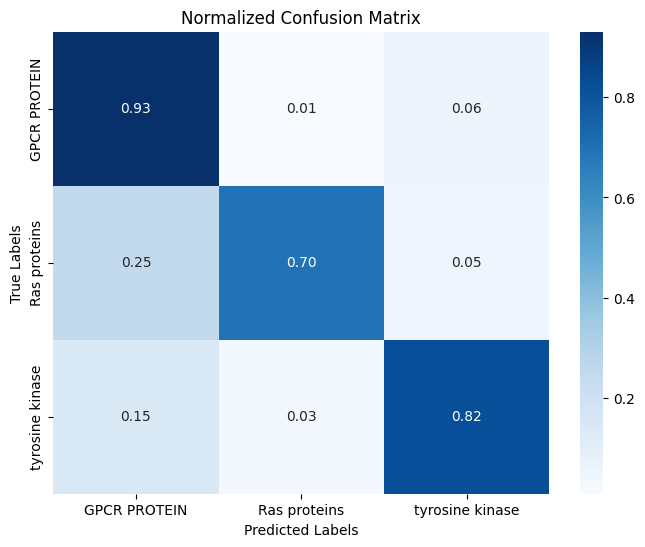

In [4]:
from torchvision.datasets import ImageFolder
class_names=ImageFolder(data_dir).classes#getting the classes names

import torch.nn.functional as F
import seaborn as sns
y_true = []
y_pred = []
y_prob=[]
def evaluate():
    
    model.eval()  #Puts the model in evaluation mode.
    

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) 
            labels =labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            # Apply softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(probabilities.cpu().numpy())  # Predicted probabilities

    print("Classification Report:")
    print(classification_report(y_true, y_pred)) #provides precision, recall, F1-score, and accuracy for each class.

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred)) # visualizes the performance of the classification
    
    
evaluate()
from sklearn.metrics import accuracy_score, roc_auc_score

auc = accuracy_score(y_true, y_pred) #get the accuracy score
print("accuracy score:", auc)
auc = roc_auc_score(y_true, y_prob, multi_class="ovr")#get the area under curve
print("area under the curve:", auc)


#define plot function for the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
 
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", 
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
#getting the classes names
plot_confusion_matrix(y_true, y_pred, class_names) #plotting the matrix

